In [1]:
from numpy  import*
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm,os
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.integrate import odeint
from scipy import linalg
import time
from numpy.linalg import det, inv, svd, norm
import numpy as np

### The Runge-Kutta numerical integration method.

In [2]:
def Runge_Kutta(to, tEnd, yo, tau, f, p):
    """Approximates the solution to a system of first-order ordinary differential equations
    using the fourth-order Runge-Kutta method.

    Args:
        to (float): Initial time.
        tEnd (float): Final time.
        yo (float): Initial condition for the dependent variable.
        tau (float): Step size.
        f (function): A function that calculates the derivative of the dependent variable
            with respect to time.
        p (dict): A dictionary containing any parameters required by the derivative function.

    Returns:
        array: An array containing the estimated values of the dependent variable at each time step.
    """

    def increment(f, t, y, tau, p):
        """Computes the weighted average of the derivatives at each of the intermediate points for a given time step.

        Returns:
            float: The weighted average of the derivatives at each of the intermediate points.
        """
        k1 = tau*f(t,y, p)
        k2 = tau*f(t+(1/4)*tau,y+(1/4)*k1, p)
        k3 = tau *f(t+(3/8)*tau,y+(3/32)*k1+(9/32)*k2, p)
        k4 = tau*f(t+(12/13)*tau,y+(1932/2197)*k1-(7200/2197)*k2+(7296/2197)*k3, p)
        k5 = tau*f(t+tau,y+(439/216)*k1-8*k2+(3680/513)*k3 -(845/4104)*k4, p)
        k6 = tau*f(t+(1/2)*tau,y-(8/27)*k1+2*k2-(3544/2565)*k3 +(1859/4104)*k4-(11/40)*k5, p)
        return (16/135)*k1+(6656/12825)*k3+(28561/56430)*k4-(9/50)*k5+(2/55)*k6
          
        
    y = [yo]
    while True:
        if tau > 0: tau = min(tau, tEnd - to)
        else: tau = max(tau, tEnd-to)
        to = to + tau
        if to == tEnd: break
        yo = yo + increment(f, to, yo, tau, p)
        y.append(yo)
    return array(y)

In [ ]:
# 0 = 15
# 1 + 2 = 0
# 3 + 4 = 1
# 5 + 6 = 2
# 12 = 3
# 4 + 6 = 7
# 11 = 5
# 7 = 8
# 9 + 10 = 8
# 10 + 11 = 13
# 12 + 9 = 14
# 14 + 13 = 15

# 0 = 1
# 0 = 2
# 0 = 15
# 1 = 3
# 1 = 4
# 2 = 5 
# 2 = 6
# 7 = 4
# 7 = 6
# 7 = 8
# 5 = 11
# 13 = 10
# 13 = 11
# 13 = 15
# 14 = 15
# 14 = 12
# 14 = 9
# 8 = 9
# 8 = 10
# 12 = 3

In [3]:
def calc_function(t, y, lambda_):

    f = np.zeros(4)

    p_ext = 1.17
    V0 = 87
    
    T, c1, c2, I, r1, r2 = [1, lambda_, 1.1, 1.13, 0.61, 0.93]

    # The first derivative for the first vessel
    f[0] = y[1]                                                 

    # The second derivative for the second vessel
    f[1] = round(-r1*T/I*y[1] - T**2/(c1*I)*y[0] + T**2*p_ext/(I*V0),100)

    # The first derivative for the second vessel
    f[2] = y[3]                                          

    # The second derivative for the second vessel
    f[3] = round(-r2*T/I*y[3] - T**2/(c2*I)*y[2] + T**2*p_ext/(I*V0),100)

    f[4] 
    return f

In [4]:
def initial_checker_for_calc(y_all,lambda_):
    left = y_all[0]
    right = y_all[-1]
    eps1 = 1
    eps2 = 0.5
    p_k = 0.1
    q = 0.1
    residuals = []

    p_ext = 1.17

    T, c1, c2, I, r1, r2 = [1, lambda_, 1.1, 1.13, 0.61, 0.93]
    
    s1 = 0.89
    
    s2 = 0.97

  # Mass Conservation
    residuals.append(2650*right[1] - 3000*left[3])
    residuals.append(2650*left[1] - 3000*right[3])

  # Bernoulli
    residuals.append((2650*right[1] / sqrt(2)/T/s1)**2 + right[0]/c1 - (3000*left[3]/sqrt(2)/T/s2)**2 - left[2]/c2)
    residuals.append((2650*left[1] / sqrt(2)/T/s1)**2 + left[0]/c1 - (3000*right[3]/sqrt(2)/T/s2)**2 - right[2]/c2 - p_ext)

    return np.array(residuals)

In [5]:
graph_nodes = []
Frech_dets = []
eigenvals = []

In [6]:
def drop_parameter(arr, idx):             
    return np.delete(arr, idx)

In [7]:
def shooting(stepping_param_idx, approx,                                                                     #!!!!!!!!!!!!!   ОТРЕДАЧИТЬ ЭТУ ЯЧЕЙКУ !!!!!!!!!!!!!!!!  сделать p не отдельной переменной, а последним элементом approx
              func,
              left,
              right,
              step,
              bc,
              eps=1e-4):
  steps = 0
  frech_ans = 1e9
  while(True):
        y = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(approx, len(approx) - 1), -step, func, approx[-1])[::-1],
                             Runge_Kutta((right + left) / 2, right, drop_parameter(approx, len(approx) - 1), step, func, approx[-1])[1:]))
        ys = y
        residuals = bc(y,approx[-1])
        #print(f'residuals {steps}', residuals)
        if (np.abs(residuals) < eps).all():
          #print('max', max(residuals))
          break
        steps += 1
        F = np.zeros((len(approx) - 1, len(approx)))
        #метод Ньютона
        for i in range(len(approx)):
            if i == stepping_param_idx: continue
            y_approx = approx.copy()
            y_approx[i] += eps
            y_i = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(y_approx, len(y_approx) - 1), -step, func, y_approx[-1])[::-1],
                                  Runge_Kutta((right + left) / 2, right, drop_parameter(y_approx, len(y_approx) - 1), step, func, y_approx[-1])[1:]))
            residuals_i = bc(y_i, approx[-1])
            
            F[:, i] = (residuals_i - residuals) / eps

        F = np.delete(F, stepping_param_idx, axis=1)
        frech_ans = np.linalg.det(F) # determinant of Fréchet matrix

        if np.linalg.det(F) == 0 or steps >= 100:    
            print('Convergence. Zero determinant of Fréchet matrix or maximum number of steps.')
            return False, steps, ys, approx, frech_ans

        res = np.dot(np.linalg.inv(F), residuals)
        res = np.insert(res, stepping_param_idx, 0)
        approx = approx - res

        # конец метода Ньютона

        ys = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(approx, len(approx) - 1), -step, func, approx[-1])[::-1],
                      Runge_Kutta((right + left) / 2, right, drop_parameter(approx, len(approx) - 1), step, func, approx[-1])[1:]))
        
  if steps>0:
    eigenvals.append(np.linalg.eig(F)[0][-2:])
  else:
    eigenvals.append(np.zeros(2))    
  return True, steps, ys, approx, frech_ans

In [8]:
def parameter_move(stepping_param_idx, approx, step):          
  previous_approximation = np.zeros(approx.shape)
  last_approximation = np.zeros(approx.shape)
  steps_streak=0
  max_steps_streak=0
  is_inf = False
  first_step=True 
  
  while abs(step) > 1e-4:

    print('step', step)
    print('shoot', approx[stepping_param_idx] + step)

    approx_try = approx.copy()                                  
    approx_try[stepping_param_idx] += step

    shoot = shooting(stepping_param_idx, approx = approx_try,
                     func = calc_function, left = 0, right = 1,
                     step = 0.01,
                     bc = initial_checker_for_calc)   
    print(shoot[0], shoot[1], shoot[3], '\n')

    if shoot[0]:    # not a critical point
      if step < 10:
        step *= 1.2

      steps_streak += 1
      previous_approximation = last_approximation
      approx = shoot[3]
      graph_nodes.append(approx)
      Frech_dets.append(shoot[4])
      last_approximation = approx

    else:
      step /= 2
      steps_streak = 0

  if not is_inf:
    print('предельная точка', approx[stepping_param_idx])

  return stepping_param_idx , np.array(last_approximation - previous_approximation), is_inf, approx

In [9]:
def parameter_change(stepping_param_idx, diff, approx):                                                            #!!!!!!!!!!!!!   ОТРЕДАЧИТЬ ЭТУ ЯЧЕЙКУ !!!!!!!!!!!!!!!!  сделать p по индексу а не по значению
  # diff - array of parameter differences at the last step

    max_idx = 0
    max1 = 0
    for i in range(len(diff)):
        if i != stepping_param_idx and abs(diff[i]) > max1:
            max1 = abs(diff[i])
            max_idx = i
    print('diff', diff)

    stepping_param_idx = max_idx
    
    print('new param', stepping_param_idx)
    if diff[max_idx] > 0: new_step = 0.01 
    else: new_step = -0.01

    print('new_step', new_step)
    
    return stepping_param_idx, new_step

In [10]:
def branches_search(stepping_param_idx, approx, step = 0.01):
    while 1 == 1:
        stepping_param_idx, diff, is_inf, approx = parameter_move(stepping_param_idx, approx, step)
        if is_inf: break
        print('Parameter change')
        stepping_param_idx, step = parameter_change(stepping_param_idx, diff, approx)
        print('approx', approx)

In [11]:
#def branches_search(stepping_param_idx, approx, step=0.01):
#    done = False
#    while not done:
#        stepping_param_idx, diff, is_inf, approx = parameter_move(stepping_param_idx, approx, step)
#        if not is_inf:
#            print('Parameter change')
#            stepping_param_idx, step = parameter_change(stepping_param_idx, diff, approx)
#            print('approx:', approx)
#        else:
#            done = True

Точки бифуркциии:

In [12]:
approx = np.zeros(5)

branches_search(len(approx) - 1, approx, step=0.01)

step 0.01
shoot 0.01
True 66 [ 0.00019613  0.00400005  0.017129   -0.00064658  0.01      ] 

step 0.012
shoot 0.022
True 35 [ 0.00404436 -0.00035001  0.01207775  0.00063613  0.022     ] 

step 0.0144
shoot 0.0364
True 71 [ 0.00068153 -0.0007053   0.01253836  0.00072758  0.0364    ] 

step 0.01728
shoot 0.053680000000000005
True 93 [ 0.00090584 -0.00129925  0.0125423   0.00072462  0.05368   ] 

step 0.020736
shoot 0.07441600000000001
True 36 [ 0.00128311 -0.00427498  0.01251094  0.00069663  0.074416  ] 

step 0.0248832
shoot 0.0992992
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00135672 -0.0058179   0.01684869 -0.00081757  0.0992992 ] 

step 0.0124416
shoot 0.08685760000000001
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00813942 -0.26088512  0.01847235 -0.00318564  0.0868576 ] 

step 0.0062208
shoot 0.08063680000000001
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
Fa

KeyboardInterrupt: 

In [13]:
graph_nodes = np.array(graph_nodes)

# Plots

graph_nodes — это list, в котором хранятся вычисленные аппроксимации решения на каждом шаге метода пристрелки при поиске разных ветвей решений. Каждый элемент списка представляет собой массив numpy, представляющий текущее приближение решения на определенном шаге. Длина списка равна количеству шагов, пройденных при поиске ветки.

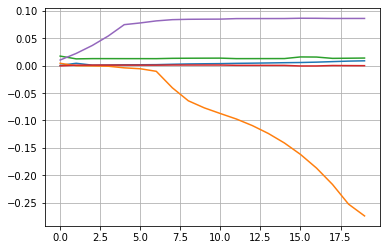

In [24]:
fig, ax = plt.subplots()

for i in range(5):
    ax.plot(graph_nodes[:, i])


plt.grid(True)

    
plt.show()

Each point on the blue line represents an approximation obtained during the iteration process in the parameter_move function, where the x-coordinate is the value of the u parameter and the y-coordinate is the corresponding value of the lambda parameter.

The approximations converge to a fixed point, so the blue line will show a clear pattern of convergence towards that point. 

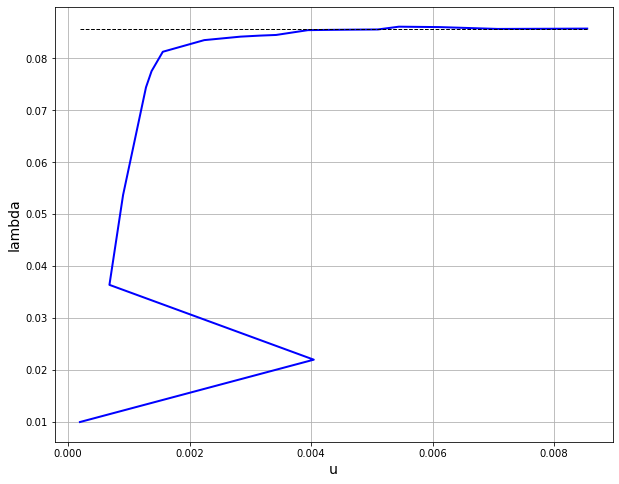

In [15]:
last_approx = graph_nodes[-1]

plt.figure(figsize=(10, 8))

plt.plot(graph_nodes[:, 0], graph_nodes[:, -1], color='blue', linewidth=2)

plt.plot([graph_nodes[0, 0], graph_nodes[-1, 0]], [last_approx[-1], last_approx[-1]], '--', color='black', linewidth=1)

plt.xlabel('u', fontsize=14)
plt.ylabel('lambda', fontsize=14)

plt.grid(True)

plt.show()

In [16]:
len(Frech_dets)

20

In [17]:
len(graph_nodes)

20

In [18]:
Frech_dets = np.array(Frech_dets)

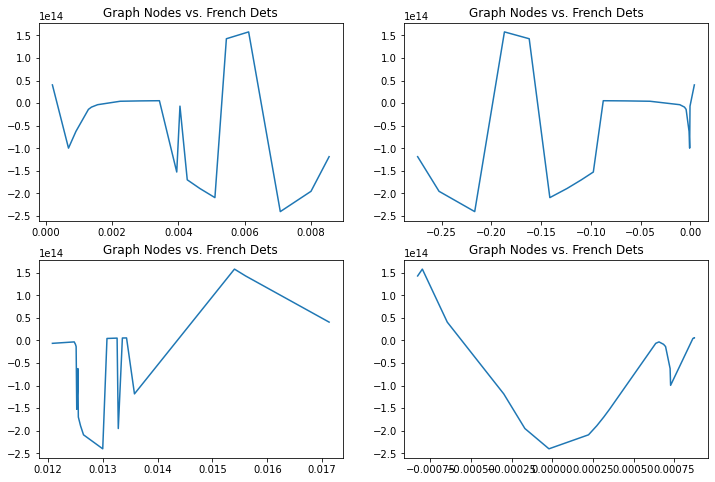

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axs[0, 1].plot(graph_nodes[np.argsort(graph_nodes[:, 1])][:, 1], Frech_dets[np.argsort(graph_nodes[:, 1])])
axs[0, 1].set_title('Graph Nodes vs. French Dets')

axs[0, 0].plot(graph_nodes[np.argsort(graph_nodes[:, 0])][:, 0], Frech_dets[np.argsort(graph_nodes[:, 0])])
axs[0, 0].set_title('Graph Nodes vs. French Dets')

axs[1, 0].plot(graph_nodes[np.argsort(graph_nodes[:, 2])][:, 2], Frech_dets[np.argsort(graph_nodes[:, 2])])
axs[1, 0].set_title('Graph Nodes vs. French Dets')

axs[1, 1].plot(graph_nodes[np.argsort(graph_nodes[:, 3])][:, 3], Frech_dets[np.argsort(graph_nodes[:, 3])])
axs[1, 1].set_title('Graph Nodes vs. French Dets')

plt.show()

In [20]:
eigenvals = np.array(eigenvals)

In [21]:
len(graph_nodes[:,0])

20

In [22]:
len(eigenvals)

20

In [ ]:
plt.plot(graph_nodes[:,0], eigenvals[:,0])
plt.plot(graph_nodes[:,0], eigenvals[:,1])